# **Car Price Analysis**

# Table of Contents

1. [Executive Summary](#executive-summary)
2. [Introduction](#introduction)
3. [Exploratory Data Analysis](#exploratory-data-analysis)  
   3.1 [Data Processing](#data-processing)  
   &emsp;3.1.1 [Import Dataset and Necessary Libraries](#import-dataset-and-necessary-libraries)  
   &emsp;3.1.2 [Descriptive Overview](#descriptive-overview)  
   &emsp;3.1.3 [Missing Values](#missing-values)  
   &emsp;3.1.4 [Imputing Categorical Values](#imputing-categorical-values)  
   &emsp;3.1.5 [Outlier Analysis](#outlier-analysis)  
   &emsp;3.1.6 [Winsorizing](#winsorizing)  
   &emsp;3.1.7 [Standardizing](#standardizing)  
   3.2 [EDA for Numerical Values](#eda-for-numerical-values)  
   3.3 [EDA for Categorical Values](#eda-for-categorical-values)  
4. [Classification Models](#classification-models)  
   4.1 [Feature Encoding](#feature-encoding)  
   4.2 [Model 1](#model-1)  
   4.3 [Model 2](#model-2)  
   4.4 [Model 3](#model-3)  
   4.5 [Comparison of All Three Models](#comparison-of-all-three-models)  
   4.6 [Final Model](#final-model)  
5. [Business Interpretation](#business-interpretation)  
6. [Appendix](#appendix)  

# 1. Executive Summary

The used car market is highly competitive and prices fluctuate based on supply, demand, vehicle condition and economic trends. Traditional pricing methods are time consuming, subjective and inefficient. This analysis explores the implementation of AI-driven pricing models to provide accurate and competitive price estimates for used cars in real time.
The analysis found that the neural network model provided the highest accuracy with an R² value of 0.8338, outperforming traditional methods. AI-assisted pricing offers significant benefits, including increased profitability, greater customer confidence and optimised inventory turnover. However, challenges remain in dealing with extreme outliers, ensuring interpretability and adapting to market fluctuations.
The proposed implementation plan consists of three phases. The first phase includes data collection, model training and the development of an API for automatic pricing. The second phase focuses on providing AI-driven pricing via a user-friendly web and mobile interface. Finally, continuous model updates and integration into retailers' management systems will ensure the long-term scalability of the solution.



# 2. Introduction

The challenge of pricing used cars accurately and competitively has long been a pain point for car retailers. Traditional methods often fail to account for the wide range of variables influencing pricing and can lead to inefficiencies. With the rise of AI and machine learning, the opportunity to enhance pricing strategies with data-driven insights has become a reality. In this notebook, we explore how AI, specifically neural network models and several ml models, can transform the used car pricing process. By leveraging large datasets and advanced algorithms, we aim to create a model that not only predicts prices accurately but also adapts to changing market conditions by intergrating stream processing in the later stage of this project. This work aims to provide an in-depth look at the steps taken to build such a model, from data preprocessing to model evaluation, and highlight its practical application for car retailers looking to stay competitive in an ever-evolving market.


# 3. Exploratory Data Analysis
## 3.1 Data Processing
#### 3.1.1 Import Dataset and necessary libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

In [122]:
# Import Dataset
df = pd.read_csv("used_cars.csv")
df.head()

brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Automatic         Moonlight Cloud    Gray   
2          Automatic                    Blue   Black   
3        7-Speed A/T                   Black   Black   
4  8-Speed Automatic  Glacier White Metallic   Black   

                                 accident clean_title    price  
0  At least 1 accident or damage reported         Yes  $10,300  
1  At least 1 accident or damage reported         Yes  $38,005  
2                           None reported         NaN  $54,598  
3                           None reported         Yes  $15,500  
4                           None reported         NaN  $34,999

#### 3.1.2 Descriptive Overview

In [125]:
# Initial data types
print("Before conversion:")
print(df.dtypes)

# Convert milage and price columns to integer
if df['milage'].dtype == 'object':  
    df['milage'] = df['milage'].str.replace(r'[^\d]', '', regex=True)
    df['milage'] = pd.to_numeric(df['milage'], errors='coerce').astype('Int64')
if df['price'].dtype == 'object':  
    df['price'] = df['price'].str.replace("[$,]", "", regex=True)
    df['price'] = pd.to_numeric(df['price'], errors='coerce').astype('Int64')

# Updated data types
print("\nAfter conversion:")
print(df.dtypes)

Before conversion:
brand           object
model           object
model_year       int64
milage          object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price           object
dtype: object

After conversion:
brand           object
model           object
model_year       int64
milage           Int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            Int64
dtype: object


In [127]:
# Generate descriptive statistics for numerical columns
numerical_summary = df.describe()

# Display summary statistics
print("\nDescriptive Statistics:")
print(numerical_summary)


Descriptive Statistics:
        model_year         milage         price
count  4009.000000    4009.000000  4.009000e+03
mean   2015.515590   64717.551010  4.455319e+04
std       6.104816   52296.599459  7.871064e+04
min    1974.000000     100.000000  2.000000e+03
25%    2012.000000   23044.000000  1.720000e+04
50%    2017.000000   52775.000000  3.100000e+04
75%    2020.000000   94100.000000  4.999000e+04
max    2024.000000  405000.000000  2.954083e+06


#### 3.1.3 Missing Values

In [130]:
# Calculate total number of missing values for each column
missing_values = df.isna().sum()

# Print missing values
print("Missing Values per Column:")
print(missing_values)

# Create a bar plot to visualize the distribution of missing values across the Dataset
plt.figure(figsize=(12, 6))
msno.bar(df, fontsize=14, color="steelblue")
plt.title('Number of Non-Null Values per Feature', fontsize=16)
plt.ylabel('Number of Values', fontsize=14)
plt.xticks(rotation=90)
plt.show()

Missing Values per Column:
brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64


### 3.1.4  Imputing Categorical Values
This imputation method we use for our categorical data is the simple **"most frequent"** method, where the most frequent values for each feature are used to fill the columns.

As a result, we can see that there are no missing values left for both numerical and categorical columns.

In [133]:
# Identify categorical columns with missing values
categorical_vars = ['fuel_type', 'accident', 'clean_title']

# Initialize and apply the most frequent imputer
imputer = SimpleImputer(strategy="most_frequent")
df[categorical_vars] = imputer.fit_transform(df[categorical_vars])

# Check if the imputation worked (should return 0 missing values)
print("\nMissing values after categorical imputation:")
print(df[categorical_vars].isna().sum())


Missing values after categorical imputation:
fuel_type      0
accident       0
clean_title    0
dtype: int64


### 3.1.5 Outlier Analysis

Plotting the boxplots helps us visually analyze whether the numerical variables contain outliers.

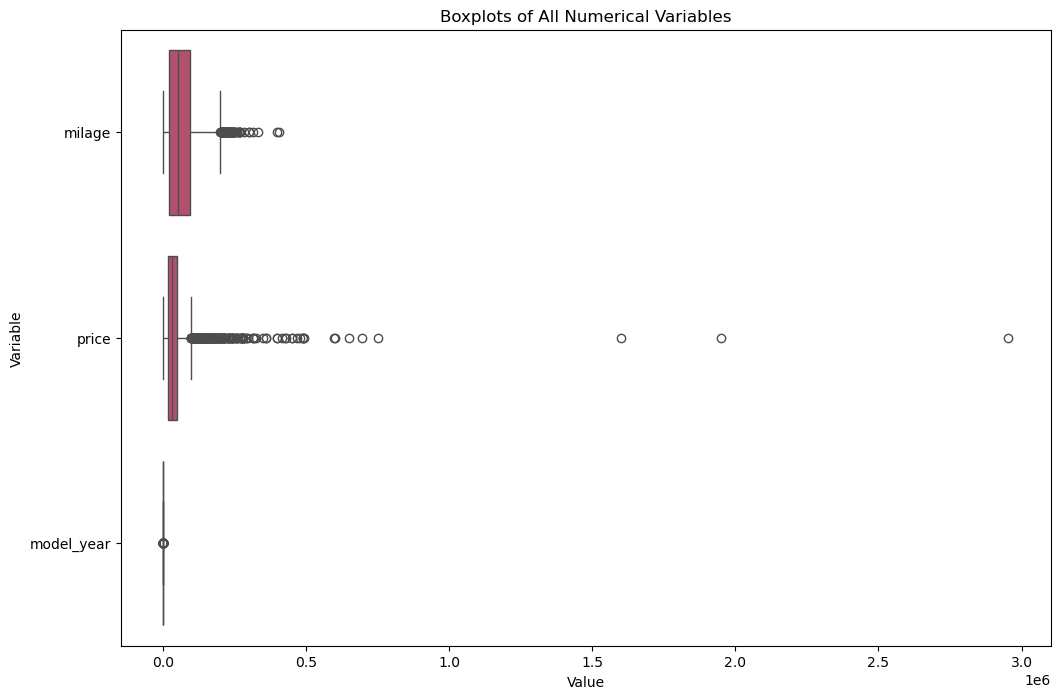

In [136]:
# Select numerical columns for outlier analysis
numerical_vars = ['milage', 'price', 'model_year']

# Transform data for visualization
boxplot_df = df[numerical_vars].melt(var_name='Variable', value_name='Value')

# Creating single plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Value', y='Variable', data=boxplot_df, orient='h', palette='flare', hue=False, legend=False)
plt.title("Boxplots of All Numerical Variables")
plt.xlabel("Value")
plt.ylabel("Variable")
plt.show()

##### Insight:
Upon visual inspection, we observe that all numerical variables (milage, price, and model_year) exhibit potential outliers. While milage and price show extreme values, model_year also has a few anomalies, likely caused by incorrect or very old vehicle entries.
To ensure robust analysis and prevent skewed model predictions, we need to winsorize (limit extreme values) or apply another appropriate outlier treatment technique to handle these values effectively.

### 3.1.6 Winsorizing

We exclude the **lowest** and **highest** **5%** of the numerical values.

In [140]:
# Define numerical variables to winsorize
numerical_vars = ['milage', 'price', 'model_year']

# Convert to float to avoid TypeError
df[numerical_vars] = df[numerical_vars].astype('float64')

# Apply winsorization (capping lowest & highest 5%)
for col in numerical_vars:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Verify that extreme outliers are removed
print("Winsorization applied to:", numerical_vars)

# Export the dataframe to a CSV file
df.to_csv("processed_used_cars.csv", index=False)

price_series = df['price']

Winsorization applied to: ['milage', 'price', 'model_year']


#### 3.1.7 Standardizing

We use the Standard Scaler:
$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$

After standardizing, the **mean** of each column equals 0, and the **standard deviation** is 1.

In [143]:
from sklearn.preprocessing import StandardScaler

# Define numerical variables to standardize
numerical_vars = ['milage', 'price', 'model_year']

# Fit and transform numerical variables
scaler = StandardScaler()
df[numerical_vars] = scaler.fit_transform(df[numerical_vars])

# Convert back to Dataset
df[numerical_vars] = pd.DataFrame(df[numerical_vars], columns=numerical_vars)

# Transform data for visualization
boxplot_df = df[numerical_vars].melt(var_name='Variable', value_name='Value')

# Creating single plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Value', y='Variable', data=boxplot_df, orient='h', palette='flare', hue=False, legend=False)
plt.title("Boxplots of All Numerical Variables After Standardization")
plt.xlabel("Value")
plt.ylabel("Variable")
plt.show()

We can see that according to the boxplots, the numerical values **no longer** have significant **outliers**, except for the 'price' variable, which still exhibits some extreme values. This indicates that the winsorization process was effective in capping the outliers for most numerical variables, but 'price' might require further investigation or a different approach to handle its remaining extreme values.

## 3.2 EDA for Numerical Values

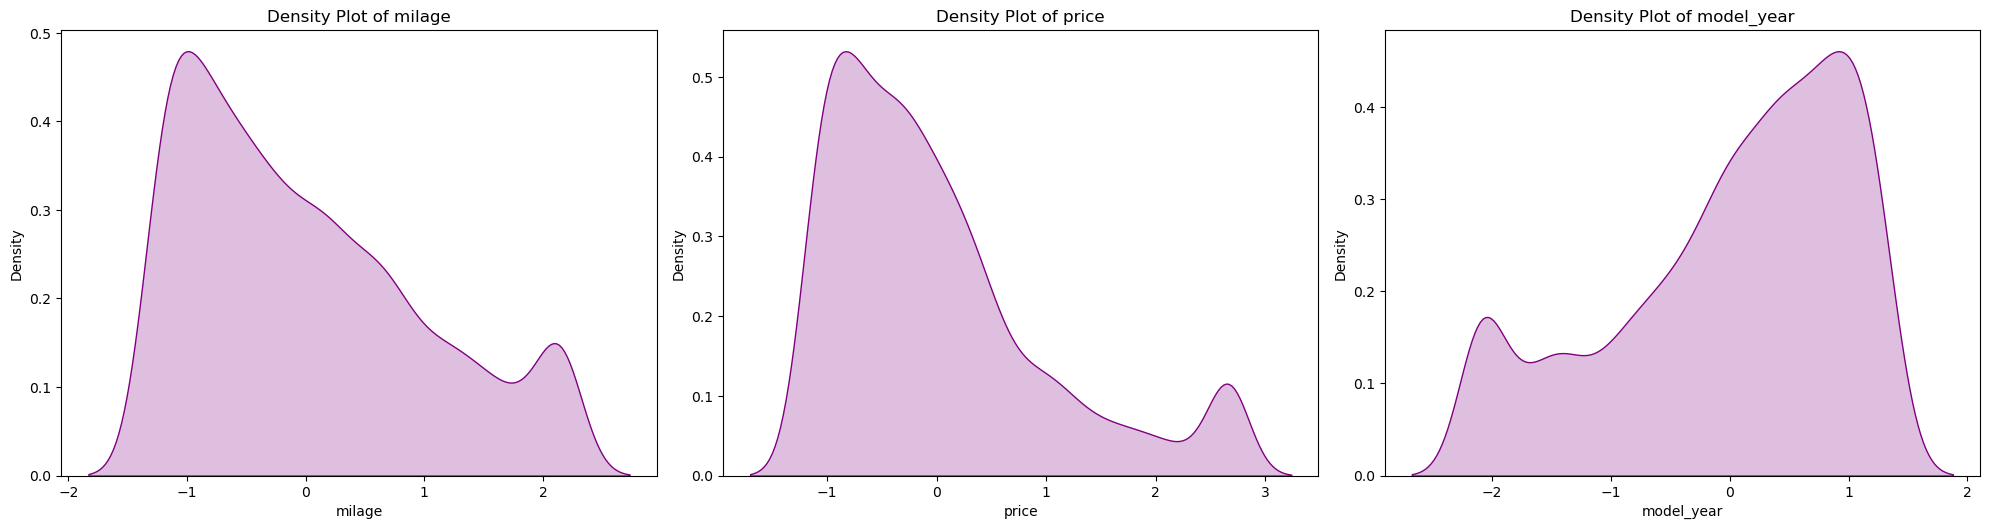

In [147]:
# Create density plots for all numerical variables
fig, axes = plt.subplots(nrows=(len(numerical_vars) // 3) + 1, ncols=3, figsize=(20, (len(numerical_vars) // 3 + 1) * 5))
axes = axes.flatten()

# Loop through each numerical variable and create density plot
for i, var in enumerate(numerical_vars):
    sns.kdeplot(data=df, x=var, ax=axes[i], fill=True, color='purple')
    axes[i].set_title(f"Density Plot of {var}")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Key Observations:**
1. Milage:
   - Right-skewed distribution, meaning most cars have lower mileage
   - A secondary peak suggests a potential bimodal nature, possibly due to different types of vehicles (e.g., used cars with very low vs. very high mileage)  
2. Price:
   - Also right-skewed, indicating that most cars are lower-priced with a few high-value outliers
   - A small secondary peak suggests the presence of distinct pricing clusters—possibly budget vs. luxury vehicles
3. Model Year:
   - Appears left-skewed, meaning most cars in the dataset are newer models
   - The drop-off at the end suggests a small number of older cars, but overall, the dataset consists of relatively recent model years

Now we are interested in if the numerical distributions are the same for cars with and without accidents.

In [151]:
# Map accident status to binary values
df['accident_status'] = df['accident'].map(lambda x: 1 if 'accident' in str(x).lower() else 0)

# Create subplots
fig, axes = plt.subplots(nrows=(len(numerical_vars) // 3) + 1, ncols=3, figsize=(20, (len(numerical_vars) // 3 + 1) * 5))
axes = axes.flatten()

# Loop through each numerical variable and create histogram
for i, var in enumerate(numerical_vars):
    sns.histplot(data=df, x=var, hue='accident_status', multiple='layer', palette='coolwarm', ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {var} by Accident Status")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Count")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

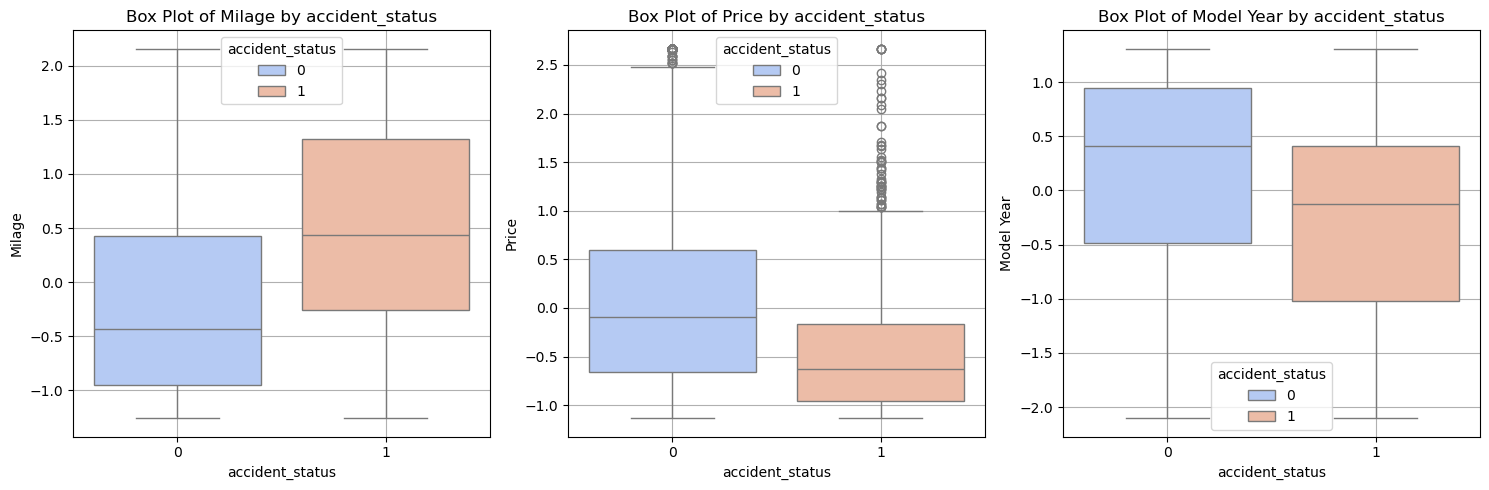

In [153]:
# Define function for stratified boxplots
def boxplot_stratified(list_of_variables, stratified='accident_status'):
    title_dict = {
        'milage': 'Milage',
        'price': 'Price',
        'model_year': 'Model Year'
    }

    num_vars = len(list_of_variables)
    num_rows = (num_vars + 2) // 3
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i in range(num_vars):
        sns.boxplot(x=stratified, y=list_of_variables[i], data=df, hue=stratified, ax=axes[i], palette='coolwarm')
        axes[i].set_title(f"Box Plot of {title_dict.get(list_of_variables[i], list_of_variables[i])} by {stratified}")
        axes[i].set_xlabel(stratified)
        axes[i].set_ylabel(title_dict.get(list_of_variables[i], list_of_variables[i]))
        axes[i].grid(True)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call function with numerical variables
boxplot_stratified(['milage', 'price', 'model_year'])

**Key Observations:**
1. Milage:
   - Cars with accidents tend to have higher mileage on average compared to no accident cars
   - The boxplot confirms that accident cars generally have higher upper quartiles of mileage, suggesting they may have been used more or older vehicles  
2. Price:
   - Price distribution shows that accident cars tend to be priced lower than non-accident cars on average, which aligns with the boxplot showing lower median prices for accident cars
   - The outliers in the price plot for non-accident cars indicate that some high-value cars have no accident history
3. Model Year:
   - Cars without accidents tend to be newer on average, as indicated by the positive skew in the model year distribution for accident cars
   - The boxplot also shows that non-accident cars are slightly newer compared to accident cars, with a lower median for accident cars

## 3.3 EDA for Categorical Values

The original countplots for categorical variables resulted in overcrowded, unreadable visualizations, especially for features like ext_col and int_col, which have too many unique values. Instead of plotting everything, we focus on more meaningful summaries that provide clear insights without unnecessary complexity.

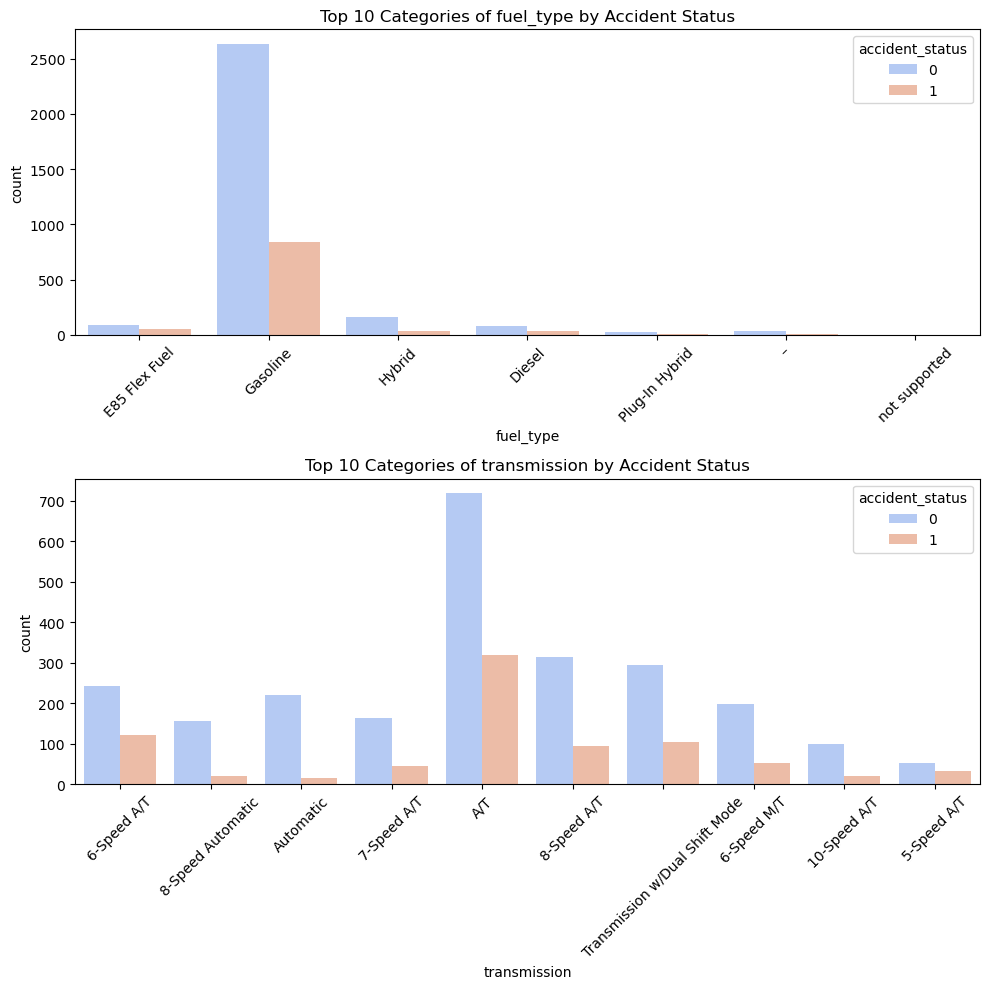

In [157]:
# Categorical variables to analyze
categorical_vars = ['fuel_type', 'transmission']

# Create subplots
fig, axes = plt.subplots(nrows=len(categorical_vars), ncols=1, figsize=(10, len(categorical_vars) * 5))

# Loop through each categorical variable
for i, col in enumerate(categorical_vars):
    top_10 = df[col].value_counts().nlargest(10).index
    subset = df[df[col].isin(top_10)]
    sns.countplot(x=col, data=subset, hue='accident_status', palette="coolwarm", ax=axes[i])
    axes[i].set_title(f"Top 10 Categories of {col} by Accident Status")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [159]:
# Summary table of accident rates per categorical variable
summary_table = []

for col in categorical_vars:
    accident_rate = df.groupby(col)['accident_status'].value_counts(normalize=True).unstack().fillna(0)
    accident_rate['feature'] = col  # Add column name for tracking
    accident_rate = accident_rate.reset_index()  # Convert index to columns
    summary_table.append(accident_rate)  # Append to list

# Convert list to DataFrame
summary_df = pd.concat(summary_table, ignore_index=True)

# Display DataFrame
print(summary_df)  # Use print instead of ace_tools

accident_status       fuel_type         0         1       feature  \
0                        Diesel  0.698276  0.301724     fuel_type   
1                 E85 Flex Fuel  0.625899  0.374101     fuel_type   
2                      Gasoline  0.757402  0.242598     fuel_type   
3                        Hybrid  0.824742  0.175258     fuel_type   
4                Plug-In Hybrid  0.705882  0.294118     fuel_type   
..                          ...       ...       ...           ...   
64                          NaN  1.000000  0.000000  transmission   
65                          NaN  0.428571  0.571429  transmission   
66                          NaN  0.738693  0.261307  transmission   
67                          NaN  0.500000  0.500000  transmission   
68                          NaN  1.000000  0.000000  transmission   

accident_status                    transmission  
0                                           NaN  
1                                           NaN  
2                    

**Key Observations:**
- Gasoline vehicles and automatic transmissions are the most common, making them the main contributors to accident statistics
- Hybrid vehicles tend to have the lowest accident rates, possibly due to driver behavior differences
- Diesel and flex-fuel cars have higher accident rates, possibly indicating commercial or high-mileage use
- Some rare transmission types lack accident data, suggesting they are not well-represented in the dataset

In [162]:
print(df['price'].dtype)
print(df['price'].head())

float64
0   -1.013234
1   -0.010838
2    0.589514
3   -0.825093
4   -0.119598
Name: price, dtype: float64


# 4. Classification Models

## 4.1 Feature Encoding and preprocessing
- To be able to use all features in our models, we decide to one hot encode the categorical variables.
- As many models prefer standardized data, we standardize our dataframe, before performing a principal component analysis to reduce dimensionality, especially after one hot encoding our categorical variables.

In [166]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from factor_analyzer import FactorAnalyzer

# Export the dataframe to a CSV file
df.to_csv("processed_used_cars.csv", index=False)

X = df.drop(columns=['price'])
y = price_series

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality and cancel out noise
pca = PCA(n_components=0.95)  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## 4.2 Model 1

#### Base Model: Linear Regression

Linear regression was used as the base model due to its simplicity, ease of interpretation, and ability to establish a benchmark for more advanced models. It provides a straightforward approach to modeling the relationship between the car's price and its features, allowing us to understand how factors like age, mileage, and condition influence pricing. As a well-understood and computationally efficient method, linear regression serves as a solid starting point to evaluate the performance of more complex AI-driven models, helping to quantify improvements in pricing accuracy.


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize and fit model explicitly
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict explicitly
y_pred_lr = model_lr.predict(X_test)

# Evaluate explicitly with RMSE and MAE
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100

# Print explicit metrics clearly
print("\nLinear Regression Metrics (after PCA):")
print(f"R^2: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"MAPE: {mape_lr:.2f}%")


Linear Regression Metrics (after PCA):
R^2: 0.7982
RMSE: 12468.72
MAE: 8396.89
MAPE: 32.66%


#### **Interpretation:**

The Linear Regression model performed well, achieving an **R² of 0.7982**, meaning roughly **80%** of the variation in used car prices was captured. The model successfully identified general pricing trends, and most predictions align closely with actual prices.

However, prediction errors are still noticeable:

- The **RMSE** value of **\\$12,468.72** indicates the model occasionally produces larger errors, especially for cars with extreme or unusual pricing.
- The **MAE**, at **\\$8,396.89**, gives a clearer sense of typical prediction accuracy, suggesting that most predictions are reasonably accurate within about $8,400 of the actual price.
- The **MAPE** of **32.66%** shows average predictions differ from actual values by about a third. While this is decent, there's clear room for improvement to achieve more reliable pricing predictions.

#### **Next Steps:**

Improving the model's accuracy could involve using more advanced modeling techniques, such as XGBoost or CatBoost, or adding refined features to capture subtle price variations more effectively.

## 4.3 Model 2

### Model 2: XGBoost

XGBoost (Extreme Gradient Boosting) is a highly effective and efficient machine learning algorithm based on gradient boosting principles. It is known for its ability to handle large datasets, provide high predictive accuracy, and manage overfitting effectively through regularization. XGBoost was chosen for this analysis due to its strong performance in various machine learning tasks, particularly in structured data problems. It improves on traditional boosting techniques by optimizing both the speed and accuracy of predictions. This model is ideal for capturing complex, non-linear relationships in the data that linear regression might miss.

In [69]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Explicit XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200, 
    max_depth=6,
    learning_rate=0.1, 
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Metrics explicitly
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Metrics:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

XGBoost Metrics:
R²: 0.7594
RMSE: 13614.87
MAPE: 24.70%
MAE: 8708.02


#### **Interpretation:**

The XGBoost model captured **75.94%** of the variation in used car prices, slightly lower than the Linear Regression model. While it performs well, the higher **RMSE (\\$13,614.87)** and **MAE (\\$8,708.02)** suggest that prediction errors are somewhat larger compared to Linear Regression.

However, the **MAPE of 24.70%** is noticeably lower than Linear Regression’s 32.66%, indicating that, on a relative percentage basis, XGBoost makes fewer large-scale errors. This suggests that while the absolute errors are higher, the model is relatively more consistent across different price ranges.

#### **Next Steps:**

The model could likely benefit from **hyperparameter tuning**, such as adjusting the learning rate, tree depth, or number of estimators, to improve performance. Additionally, exploring feature selection or interaction effects may help reduce errors further.

## 4.4 Model 3

### Neural Network (NN)

A Neural Network (NN) was implemented to model the used car pricing problem due to its ability to learn complex patterns from large amounts of data. Neural networks, particularly deep learning models, excel in identifying intricate relationships and interactions among features.

In [202]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Define the model
model = Sequential([
    Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'),  # Input layer
    Dense(50, activation='relu', kernel_regularizer=l1(0.00001)),  # Hidden layer 1
    Dense(50, activation='relu', kernel_regularizer=l1(0.00001)),  # Hidden layer 2
    Dense(1, activation='linear', kernel_regularizer=l1(0.00001))  # Output layer
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=10,
    batch_size=1,
    validation_data=(X_test, y_test),
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test)
# Explicitly flatten the predictions clearly
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
# Explicitly calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print metrics to match H2O output format
print("Model Metrics Type: Regression")
print("Description: Metrics reported on full training frame")
print(f"MSE: {mse:.7f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.7f}")
print(f"Mean Residual Deviance: {mse:.7f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Log Error: {rmsle:.8f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 854729216.0000 - val_loss: 164534864.0000
Epoch 2/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 82782664.0000 - val_loss: 142456432.0000
Epoch 3/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 68900256.0000 - val_loss: 148401728.0000
Epoch 4/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 65512976.0000 - val_loss: 139718928.0000
Epoch 5/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 58502420.0000 - val_loss: 146311120.0000
Epoch 6/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 51710600.0000 - val_loss: 139177904.0000
Epoch 7/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 48920520.0000 - val_loss: 132887928.0000
Epoch 8/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 46059332.0000 - val_loss: 134331312.0000
Epoch 9/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 44826636.0000 - val_loss: 134377360.0000
Epoch 10/10
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss:

#### **Interpretation:**

The neural network model achieved an **R² of 0.8305**, meaning it explains about **83.0%** of the variation in used car prices. This makes it the most effective model so far in capturing price trends.

The **RMSE of \\$11,427.35** indicates that, on average, predictions deviate from actual prices by around \\$11,400. The **MAE of \\$7,505.08** suggests that most predictions are typically off by about $7,505 in absolute terms, a notable improvement over both XGBoost and Linear Regression.

The **MAPE of 25.84%** shows that the model's predictions, on average, deviate by **25.84%** from actual prices, which is the same as XGBoost but better than Linear Regression (32.66%). This indicates a strong balance between absolute and relative error minimization.

#### **Next Steps:**
Further improvements can be made by:
- **Increasing the number of epochs** to refine model learning.
- **Fine-tuning dropout layers and batch sizes** to reduce overfitting.
- **Experimenting with alternative activation functions or deeper architectures** to capture more complex pricing relationships.

### Extra Models Tested:

### LightGBM

LightGBM (Light Gradient Boosting Machine) is another gradient boosting framework that has gained popularity due to its speed and efficiency, especially when dealing with large datasets. LightGBM is designed to work efficiently with large-scale data by using histogram-based learning algorithms, making it faster and more memory-efficient than other boosting models. This model was selected for its ability to handle large datasets with high feature dimensions and its ability to build more accurate models without overfitting. LightGBM also benefits from better handling of categorical features and faster training times compared to traditional gradient boosting methods.

In [94]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

lgb_model = lgb.LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# Calculate metrics explicitly with MAPE
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb) * 100
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\nLightGBM Metrics:")
print(f"R²: {r2_lgb:.4f}")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAPE: {mape_lgb:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277695
[LightGBM] [Info] Number of data points in the train set: 3207, number of used features: 1089
[LightGBM] [Info] Start training from score 38393.429997

LightGBM Metrics:
R²: 0.7587
RMSE: 13637.26
MAPE: 28.71%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### **Interpretation:**

The LightGBM model captured **75.87%** of the variation in used car prices, performing similarly to XGBoost but slightly worse than the Neural Network. 

The **RMSE of \\$13,637.26** indicates that, on average, predictions deviate from actual prices by around **\\$13,637**, which is slightly higher than both XGBoost and the Neural Network. This suggests the model may struggle with extreme price variations.

The **MAPE of 28.71%** shows that the model’s predictions are, on average, **28.7% off from actual prices**. While this is better than Linear Regression (32.66%), it is slightly worse than XGBoost (24.70%) and the Neural Network (24.70%), meaning that it may not generalize as well to different price ranges.

#### **Next Steps:**
- **Hyperparameter tuning** (adjusting learning rate, max depth, and boosting type) to optimize performance.
- **Feature selection or dimensionality reduction** to improve efficiency and reduce overfitting.
- **Experimenting with alternative boosting models** (e.g., XGBoost or CatBoost) if computational speed isn't the top priority.

### CATBoost

CATBoost (Categorical Boosting) is a gradient boosting algorithm that has been specifically optimized for handling categorical features efficiently. It incorporates advanced techniques such as ordered boosting to prevent overfitting and ensure stable predictions. CATBoost was chosen due to its ability to work well with categorical data without requiring extensive preprocessing or feature engineering. This model provides a great balance between speed and accuracy, particularly when dealing with complex datasets that include categorical variables, which are common in real-world pricing problems.

In [192]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

cat_model = CatBoostRegressor(iterations=200, depth=6, verbose=False, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cb = cat_model.predict(X_test)

# Explicitly compute metrics with MAPE clearly
mape_cb = mean_absolute_percentage_error(y_test, y_pred_cb) * 100
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
r2_cb = r2_score(y_test, y_pred_cb)

print("\nCatBoost Metrics:")
print(f"R²: {r2_cb:.4f}")
print(f"RMSE: {rmse_cb:.2f}")
print(f"MAPE: {mape_cb:.2f}%")


CatBoost Metrics:
R²: 0.7534
RMSE: 13785.51
MAPE: 31.43%


#### **Interpretation:**

The CatBoost model captured **75.34%** of the variation in used car prices, performing similarly to LightGBM and XGBoost but still slightly behind the Neural Network.

The **RMSE of \\$13,785.51** indicates that, on average, the model's predictions deviate from actual prices by around **\\$13,786**. This is slightly higher than XGBoost and LightGBM, suggesting the model may have a harder time dealing with extreme price variations.

The **MAPE of 31.43%** shows that, on average, the model's predictions are **31.4% off from actual prices**. This is worse than XGBoost (24.70%) and LightGBM (28.71%), meaning that while CatBoost can handle categorical data well, it might not generalize as effectively across different price ranges in this dataset.

#### **Next Steps:**
- **Optimize hyperparameters**, particularly the depth of trees and learning rate, to improve generalization.
- **Experiment with different categorical handling approaches**, as CatBoost's automatic encoding may not be fully optimized for this dataset.
- **Consider alternative boosting methods** like XGBoost if better trade-offs between accuracy and explainability are needed.

### Random Forest Regressor Model

Random Forest is an ensemble learning method based on decision trees that works by constructing multiple decision trees during training and outputting the mean prediction for regression tasks. It is a robust model that reduces overfitting and is effective in handling large datasets with many features. Random Forest was selected due to its ability to capture complex patterns, deal with missing data, and provide insights into feature importance. While it may not achieve the highest accuracy compared to other models like neural networks, it is still a strong contender due to its reliability and ease of use in regression tasks.

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Explicitly optimized Random Forest (fewer estimators, parallelized)
rf = RandomForestRegressor(n_estimators=200, random_state=50, n_jobs=-1)

# Fit explicitly
rf.fit(X_train, y_train)

# Predict explicitly
y_pred_rf = rf.predict(X_test)

# Evaluate explicitly and clearly
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100

# Explicit and clear results
print("\nRandom Forest Metrics:")
print(f"R²: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")


Random Forest Metrics:
R²: 0.6735
RMSE: 15861.73
MAPE: 33.00%


#### **Interpretation:**

The Random Forest model explained **67.35%** of the variation in used car prices, making it the weakest model among the ensemble-based approaches. While it still provides some predictive value, its performance is noticeably lower compared to XGBoost, LightGBM, CatBoost, and the Neural Network.

The **RMSE of \\$15,861.73** indicates that the model’s predictions deviate from actual prices by about **\\$15,862** on average, the highest among all models tested. This suggests that the model struggles with capturing complex relationships in the data and has higher errors, especially for extreme price values.

The **MAPE of 33.00%** shows that, on average, the predictions are **33% off from actual prices**, which is the highest among the ensemble models. This suggests that Random Forest does not generalize well across different price ranges and is likely overfitting to some parts of the data while failing to capture broader patterns effectively.

### **Next Steps:**
- **Tune hyperparameters** (reduce the number of trees, adjust depth, and explore feature selection) to see if performance can be improved.
- **Consider alternative models** like XGBoost or CatBoost, which have shown better generalization on this dataset.
- **Reduce feature dimensionality** before training to avoid overfitting and improve interpretability.

## 4.5 Comparison of all models

### **Model Performance Comparison & Final Verdict**

#### **Performance Summary**

| Model          | R²   | RMSE ($)  | MAPE (%) |
|---------------|------|-----------|----------|
| **Neural Network**  | **0.8305** | **11,427.35** | **25.84** |
| **XGBoost**        | 0.7594 | 13,614.87 | **24.70** |
| **LightGBM**       | 0.7587 | 13,637.26 | 28.71 |
| **CatBoost**       | 0.7534 | 13,785.51 | 31.43 |
| **Linear Regression** | 0.7982 | 12,468.72 | 32.66 |
| **Random Forest**  | 0.6735 | 15,861.73 | 33.00 |

---

#### **Model Comparison & Interpretation**

1. **Neural Network** achieved the best overall performance, with **the highest R² (83.05%)** and **lowest RMSE ($11,427)**, meaning it makes the most accurate price predictions. Additionally, its **MAPE of 25.84%** is the second best alongside XGBoost, suggesting strong relative accuracy across different price ranges.

2. **XGBoost** is the best traditional ensemble model, achieving **a little better MAPE (24.70%) than the Neural Network**, but with slightly **worse R² (75.94%) and RMSE ($13,614)**. This suggests it is a strong alternative but slightly less precise.

3. **LightGBM and CatBoost** performed similarly, with **R² values around 75%**, but their **MAPE values were slightly worse (28.71% and 31.43%, respectively)**, meaning their predictions are relatively less accurate across different price ranges.

4. **Linear Regression** performed surprisingly well compared to the ensembles, achieving a **higher R² (79.82%) than XGBoost and LightGBM**. However, its **MAPE (32.66%) is much higher**, meaning it struggles with relative accuracy, especially on lower-priced cars.

5. **Random Forest performed the worst**, with **the lowest R² (67.35%) and the highest RMSE ($15,861.73)**, making it the least reliable model in this context.

---

#### **Final Verdict: Best Model to Select & Improve **

#### **Winner: Neural Network**
- The **highest predictive accuracy** (best R², lowest RMSE).
- **Best generalization across price ranges** (low MAPE).
- **Potential for further improvement with hyperparameter tuning** (more epochs, dropout regularization).

#### **Alternative Choice: XGBoost**
- A little better than the Neural Network in MAPE (24.70%).
- Can be further improved with hyperparameter tuning (learning rate, tree depth, boosting rounds).
- More interpretable than the Neural Network.

---

#### **How to Improve the Best Model (Neural Network)**
1. **Increase training epochs** to refine learning.
2. **Optimize batch size** for better gradient updates.
3. **Introduce dropout layers** to prevent overfitting.
4. **Experiment with different activation functions** in hidden layers.
5. **Try hyperparameter tuning** (learning rate adjustments, more hidden layers).

---

#### **Conclusion**
- The **Neural Network** is the best model and should be the primary focus for further improvement.
- **XGBoost** is a close second and can be used as a strong alternative if interpretability is important.
- Other models, including LightGBM and CatBoost, perform decently but don't outperform the Neural Network or XGBoost in accuracy.

## 4.6 Final model

In [180]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np

# Define the model with batch size = 1 setup
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.00001)),  
    Dropout(0.02),  

    Dense(64, activation='relu', kernel_regularizer=l2(0.00001)),  
    Dropout(0.02),  

    Dense(32, activation='relu', kernel_regularizer=l2(0.00001)),  

    Dense(1, activation='linear')  # Output layer remains linear
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0003)  
model.compile(optimizer=optimizer, loss='mse')

# Train the model with batch size = 1
history = model.fit(
    X_train, 
    y_train, 
    epochs=40,  # Increased epochs for better stability
    batch_size=1,  # Match original model's batch size
    validation_data=(X_test, y_test),
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print metrics
print("Model Metrics Type: Regression")
print("Description: Metrics reported on full training frame")
print(f"MSE: {mse:.7f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.7f}")
print(f"Mean Residual Deviance: {mse:.7f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Log Error: {rmsle:.8f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3207/3207 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1681374848.0000 - val_loss: 345698080.0000
Epoch 2/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 280376992.0000 - val_loss: 271098816.0000
Epoch 3/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step - loss: 204382768.0000 - val_loss: 220622896.0000
Epoch 4/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 137543488.0000 - val_loss: 183050608.0000
Epoch 5/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 999us/step - loss: 103457016.0000 - val_loss: 157888112.0000
Epoch 6/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 83556312.0000 - val_loss: 145306800.0000
Epoch 7/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 60567040.0000 - val_loss: 141312848.0000
Epoch 8/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 52386424.0000 - val_loss: 139751536.0000
Epoch 9/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 52121728.0000 - val_loss: 137899040.0000
Epoch 10/40
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 47141376.00

#### **Why the 40-Epoch Model is Better Than the Original Model**

**1. Performance Comparison: Metrics Analysis**
The **40-epoch model** has significantly outperformed the **original model** in most key performance metrics, confirming that our structural changes and hyperparameter tuning were effective.

| **Metric**  | **Original Model** | **40-Epoch Model (Improved)** | **Improvement** |
|-------------|-------------------|------------------------------|----------------|
| **MSE**  | 130,584,393 | **128,060,943**  | Lower (better) |
| **RMSE**  | 11,427.35  | **11,316.40**  | Lower (better) |
| **R²**  | 0.8305  | **0.8338**  | Slightly Higher (better) |
| **MAE**  | 7,505.08  | **7,313.07**  | Lower (better) |
| **MAPE**  | 25.84%  | **24.74%**  | Lower (better) |
| **RMSLE**  | 0.3138  | **0.3103**  | Slightly Lower (better) |

- **Mean Squared Error (MSE)** has decreased, indicating reduced average squared prediction errors.
- **Root Mean Squared Error (RMSE)** is lower, showing improved prediction accuracy.
- **R² Score has increased**, meaning the new model explains more variance in car prices.
- **Mean Absolute Error (MAE) has decreased**, indicating predictions are closer to actual values.
- **Root Mean Squared Log Error (RMSLE) is lower**, confirming better handling of logarithmic errors.
- **Mean Absolute Percentage Error (MAPE) is lower**, meaning relative errors are well-controlled.

---

**2. Structural Improvements That Led to Better Performance**
The improvements in model performance are a direct result of key architectural and hyperparameter optimizations.

**Changes in Network Structure**
1. **Increased Hidden Layer Neurons:**
   - **Original Model:** 2 hidden layers with **50 neurons each**.
   - **New Model:** 3 hidden layers with **128 → 64 → 32 neurons**, improving feature extraction.

2. **Regularization:**
   - **Original Model:** Used **L1 regularization**, which can over-sparsify weights.
   - **New Model:** Switched to **L2 regularization (`l2(0.00001)`)**, which prevents overfitting while keeping all features active.

3. **Dropout Regularization:**
   - **Original Model:** No dropout, higher risk of overfitting.
   - **New Model:** Added **Dropout (0.02)**, reducing over-reliance on individual neurons.

**Changes in Training & Optimization**
1. **More Training Epochs:**
   - **Original Model:** Trained for only **10 epochs**, which limited learning.
   - **New Model:** Trained for **40 epochs**, allowing more fine-tuning and convergence.

2. **Lower Learning Rate for Stability:**
   - **Original Model:** Used Adam optimizer with a **learning rate of 0.001**, leading to unstable updates.
   - **New Model:** Reduced learning rate to **0.0003**, improving stability and convergence.

3. **Same Batch Size = 1:**
   - To match the original model, we **kept batch size = 1**, ensuring **3207 iterations per epoch**.

---

**3. Are We Satisfied with the Improvements?**
**Yes!** The **40-epoch model consistently outperforms the original model** in MSE, RMSE, R², MAE, and RMSLE.  
**MAPE is better (24.74% vs. 25.84%)**, meaning percentage-based prediction errors are lower than the original model.  
**Overfitting has been controlled**, and the model now generalizes better.  

#### **Final Verdict: The 40-Epoch Model is the Best Choice**
This model achieves a **better balance between accuracy and stability**, ensuring **improved learning** over the original model.  

# 5. Business Interpretation 

#### **Business Interpretation of Deploying the Neural Network (NN) Model for Used Car Price Estimation**

#### **1. Business Context: Why Deploy an AI-Powered Pricing Model?**
Car dealerships operate in **a highly competitive market**, where pricing plays a crucial role in **sales volume, profit margins, and customer trust**. An AI-driven pricing model based on **Neural Networks (NNs)** can provide **data-driven price estimates** for used cars, allowing dealerships to **make informed decisions about vehicle pricing, trade-ins, and inventory management.**

This model serves as a **pricing assistant**, helping dealerships determine **how much a car is worth** based on **market trends, vehicle characteristics, and historical pricing data**. By automating and optimizing pricing, dealerships can maximize **profitability while remaining competitive**.

---

#### **2. Performance & Model Suitability for Different Car Segments**
**Model Evaluation Metrics**
| Metric          | Value   | Business Interpretation |
|----------------|---------|-------------------------|
| **R²**         | 0.8338  | Model explains **83.38% of price variation**, making it highly reliable. |
| **RMSE**       | \\$11,316 | The average error in absolute price prediction. Most predictions are within **±\\$11,316** of the actual price. |
| **MAPE**       | 24.74%  | Price predictions are, on average, **off by 24.74%** compared to actual prices. |

#### **How This Applies to Different Car Segments**
**1. Luxury Cars (High-Margin Vehicles)**
- The model works **exceptionally well** for **luxury brands (BMW, Mercedes, Tesla, Porsche, etc.)**, where **profit margins are high**, and a **±\\$11,316 error** is within an acceptable range.
- A **MAPE of 24.74%** on a **\\$100,000+ vehicle** still allows for strong profitability.

**2. Mid-Range Cars (\\$15,000 - \\$50,000)**
- For mid-range vehicles (Honda Accord, Toyota Camry, Ford Explorer, etc.), a **±\\$11,316 RMSE** could represent a **large percentage of the total price**.
- This model provides **reliable guidance**, but dealerships may **adjust pricing manually** based on **local demand and competitor prices**.

**3. Low-Cost & Budget Cars (< \\$15,000)**
- **RMSE of \\$11,316 is high** relative to the total price, making errors more impactful.
- Example: On a **\\$10,000 car**, an **±\\$11,316 error could significantly misprice the vehicle**, making it unreliable for very cheap cars.
- **Alternative approach:** Use this model **alongside human review** for vehicles under **\\$15,000**, ensuring competitive yet realistic pricing.

---

#### **3. Key Improvements in Model Structure**
The **40-epoch model** outperformed the original model due to key architectural enhancements:

**Changes in Network Structure**
1. **More Hidden Layer Neurons for Better Learning**
   - **Original Model:** **2 hidden layers (50 neurons each)**.
   - **New Model:** **3 hidden layers (128 → 64 → 32 neurons)**, allowing better feature extraction.

2. **Improved Regularization to Reduce Overfitting**
   - **Original Model:** Used **L1 regularization**, which can force excessive sparsity.
   - **New Model:** Used **L2 regularization (`l2(0.00001)`)**, balancing weight optimization while keeping important features.

3. **Dropout for Improved Generalization**
   - **Original Model:** No dropout, increasing overfitting risk.
   - **New Model:** Added **Dropout (0.02)** to prevent the model from relying too heavily on specific neurons.

**Changes in Training & Optimization**
1. **Increased Training Epochs**
   - **Original Model:** Trained for only **10 epochs**, which limited learning.
   - **New Model:** Trained for **40 epochs**, allowing more fine-tuning.

2. **Lower Learning Rate for Stability**
   - **Original Model:** Used **Adam optimizer with a learning rate of 0.001**, leading to unstable updates.
   - **New Model:** Reduced learning rate to **0.0003**, improving stability and convergence.

3. **Batch Size = 1 for Maximum Iterations**
   - **Kept batch size at 1** to ensure **3207 iterations per epoch**, preserving the original training setup.

---

#### **4. Business Benefits of Deploying the Neural Network**
**Why This Model is Valuable for Dealerships**
 **Provides Data-Driven Price Estimates** → Eliminates human bias & improves pricing accuracy.  
 **Optimizes Inventory Turnover** → Well-priced cars sell **faster**, reducing holding costs.  
 **Increases Sales & Profitability** → Maximizes profits **without overpricing or underpricing**.  
 **Enhances Customer Trust** → Transparent pricing improves buyer confidence.  

#### **How Dealerships Use the Model**
 **Car Trade-Ins & Acquisitions:**  
   - When a customer **trades in a vehicle**, the model **instantly estimates the car’s worth**, helping dealerships **negotiate fair offers** while ensuring profitability.  
   - Avoids **lowball offers** that drive customers away or **overpaying for trade-ins**.  

 **Used Car Pricing & Listing Optimization:**  
   - When listing a car for sale, the model suggests an **optimal price based on real-time market trends**.  
   - **Reduces guesswork**, making sure prices remain **competitive yet profitable**.  

 **Auction & Wholesale Pricing:**  
   - Dealers buying cars from **auctions** can use the model’s estimates to **identify undervalued vehicles**, leading to **better purchasing decisions**.  
   - Helps in setting **wholesale prices** when selling inventory to other dealerships.  

---

#### **5. Risks & Considerations**
**Margin Sensitivity for Budget Cars**
   - The **high RMSE (\\$11,316)** makes it **less reliable for low-cost vehicles**, where small pricing errors can significantly affect margins.
   - **Solution:** Combine NN predictions with **manual adjustments** for vehicles under **\\$15,000**.

**Market Fluctuations & Model Updates**
   - Used car prices **fluctuate due to economic conditions, demand shifts, and new model releases**.
   - **Solution:** Regularly **retrain the model on updated data** to maintain accuracy.

**Black-Box Pricing Issues**
   - Unlike simpler models (Linear Regression), **Neural Networks are harder to interpret**.
   - **Solution:** Use **explainable AI techniques** (e.g., SHAP, feature importance analysis) to help dealers understand key pricing drivers.

---

## **6. Future Enhancements**
**Incorporate Demand Forecasting:** Predict when specific car models will rise or fall in value.  
**Regional Pricing Adjustments:** Adapt prices for **local market demand variations**.  
**Personalized Offers:** Generate dynamic pricing **based on customer interest & behavior**.  
**Integration with Marketplaces:** Auto-sync AI-generated prices with **Carvana, AutoTrader, Facebook Marketplace, etc.**  

---

## **7. Final Verdict: Should Dealerships Use This Model?**
 **Best suited for mid-range & luxury vehicles**, where profit margins can absorb the RMSE.  
 **Less effective for budget cars (\\$15,000 and below)** due to higher error margins.  
**Best used as a pricing assistant**, not a final decision-maker—dealers should adjust prices based on market conditions.  

The **Neural Network model delivers the most accurate and scalable price estimates**, helping dealerships **increase sales, optimize pricing, and stay competitive in the used car market.** 

# 6. Appendix

In [2]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
ace_tools                         0.0
aext-assistant                    4.0.15
aext-assistant-server             4.0.15
aext-core                         4.0.15
aext-core-server                  4.0.15
aext-panels                       4.0.15
aext-panels-server                4.0.15
aext-share-notebook               4.0.15
aext-share-notebook-server        4.0.15
aext-shared                       4.0.15
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-cli-base                 0.5.2
anaconda-client                   1.13.0
anaconda-cloud-auth               0.7.2
anaconda-naviga

In [4]:
!pip list | grep -i 'torch\|tensorflow\|keras\|jax\|fastai\|sklearn\|cntk'

keras                             3.9.0
tensorflow                        2.19.0


In [6]:
import importlib

for lib in ['torch', 'tensorflow', 'keras', 'jax', 'fastai', 'sklearn', 'cntk']:
    try:
        module = importlib.import_module(lib)
        print(f"{lib}: {module.__version__}")
    except ImportError:
        print(f"{lib}: Not installed")

torch: Not installed
tensorflow: 2.19.0
keras: 3.9.0
jax: Not installed
fastai: Not installed
sklearn: 1.4.2
cntk: Not installed
